In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import requests
from io import StringIO
from datetime import timedelta, datetime
from functions_evaluation import *
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.font_manager as fm
font_path = "font-folder/Roboto-Regular.ttf"
font_path_bold = "font-folder/Roboto-Bold.ttf"
font_prop = fm.FontProperties(fname=font_path, size=20)
font_prop_legend = fm.FontProperties(fname=font_path, size=16)
font_prop_title = fm.FontProperties(fname=font_path_bold, size=22)
import matplotlib as mpl
mpl.rcParams['font.family'] = font_prop.get_name()
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Loading surveillance data for evaluation: last surveillance file
start_date = datetime(2023, 9, 9)
state = 'US'
github_repo = "cdcepi/FluSight-forecast-hub"
github_directory = "auxiliary-data/target-data-archive"
surveillance_file = "target-hospital-admissions_2024-04-27.csv"
horizon_to_start = 5
df_surv = loading_surveillance_eval(start_date, github_repo, github_directory, surveillance_file, state, horizon_to_start)
df_surv.rename(columns={'horizon': 'round'}, inplace=True)
df_surv.head()

,date,location,location_name,hospitalizations,weekly_rate,round
1582,2023-10-07,US,US,1116,0.335942,5
1529,2023-10-14,US,US,1218,0.366647,6
1476,2023-10-21,US,US,1474,0.443709,7
1423,2023-10-28,US,US,1610,0.484648,8
1370,2023-11-04,US,US,1974,0.594220,9


In [3]:
df_wis = pd.read_csv("../output_data/performance_forecasting/wis_adaptive_ensemble2.csv")
df_wis = df_wis.merge(df_surv[['date', 'hospitalizations', 'round']], on=['round'], how='left')

df_mae = pd.read_csv("../output_data/performance_forecasting/mae_adaptive_ensemble2.csv")
df_mae = df_mae.merge(df_surv[['date', 'hospitalizations', 'round']], on=['round'], how='left')

df_cov = pd.read_csv("../output_data/performance_forecasting/coverage_adaptive_ensemble2.csv")
df_cov = df_cov.merge(df_surv[['date', 'hospitalizations', 'round']], on=['round'], how='left')

In [19]:
df_wis

,horizon,k_perc,round,wis_adaptive,wis_baseline,wis_flusight,wis_adaptive_baseline,wis_adaptive_flusight,date,hospitalizations
0,0,5,6,102.202759,322.999838,162.264737,0.316417,0.629852,2023-10-14,1218
1,0,5,7,96.968091,401.427733,197.621614,0.241558,0.490676,2023-10-21,1474
2,0,5,8,109.253361,422.483221,162.146175,0.258598,0.673795,2023-10-28,1610
3,0,5,9,169.352045,350.566391,221.685064,0.483081,0.763931,2023-11-04,1974
4,0,5,10,372.051193,600.136826,370.419915,0.619944,1.004404,2023-11-11,2695
...,...,...,...,...,...,...,...,...,...,...
515,3,75,27,1927.975715,3556.884735,1496.327088,0.542041,1.288472,2024-03-09,9113
516,3,75,28,1859.319832,2983.781311,1354.812458,0.623142,1.372382,2024-03-16,7268
517,3,75,29,1502.509492,2413.072282,1002.187332,0.622654,1.499230,2024-03-23,5911
518,3,75,30,1082.311924,2223.462224,896.339511,0.486769,1.207480,2024-03-30,5445


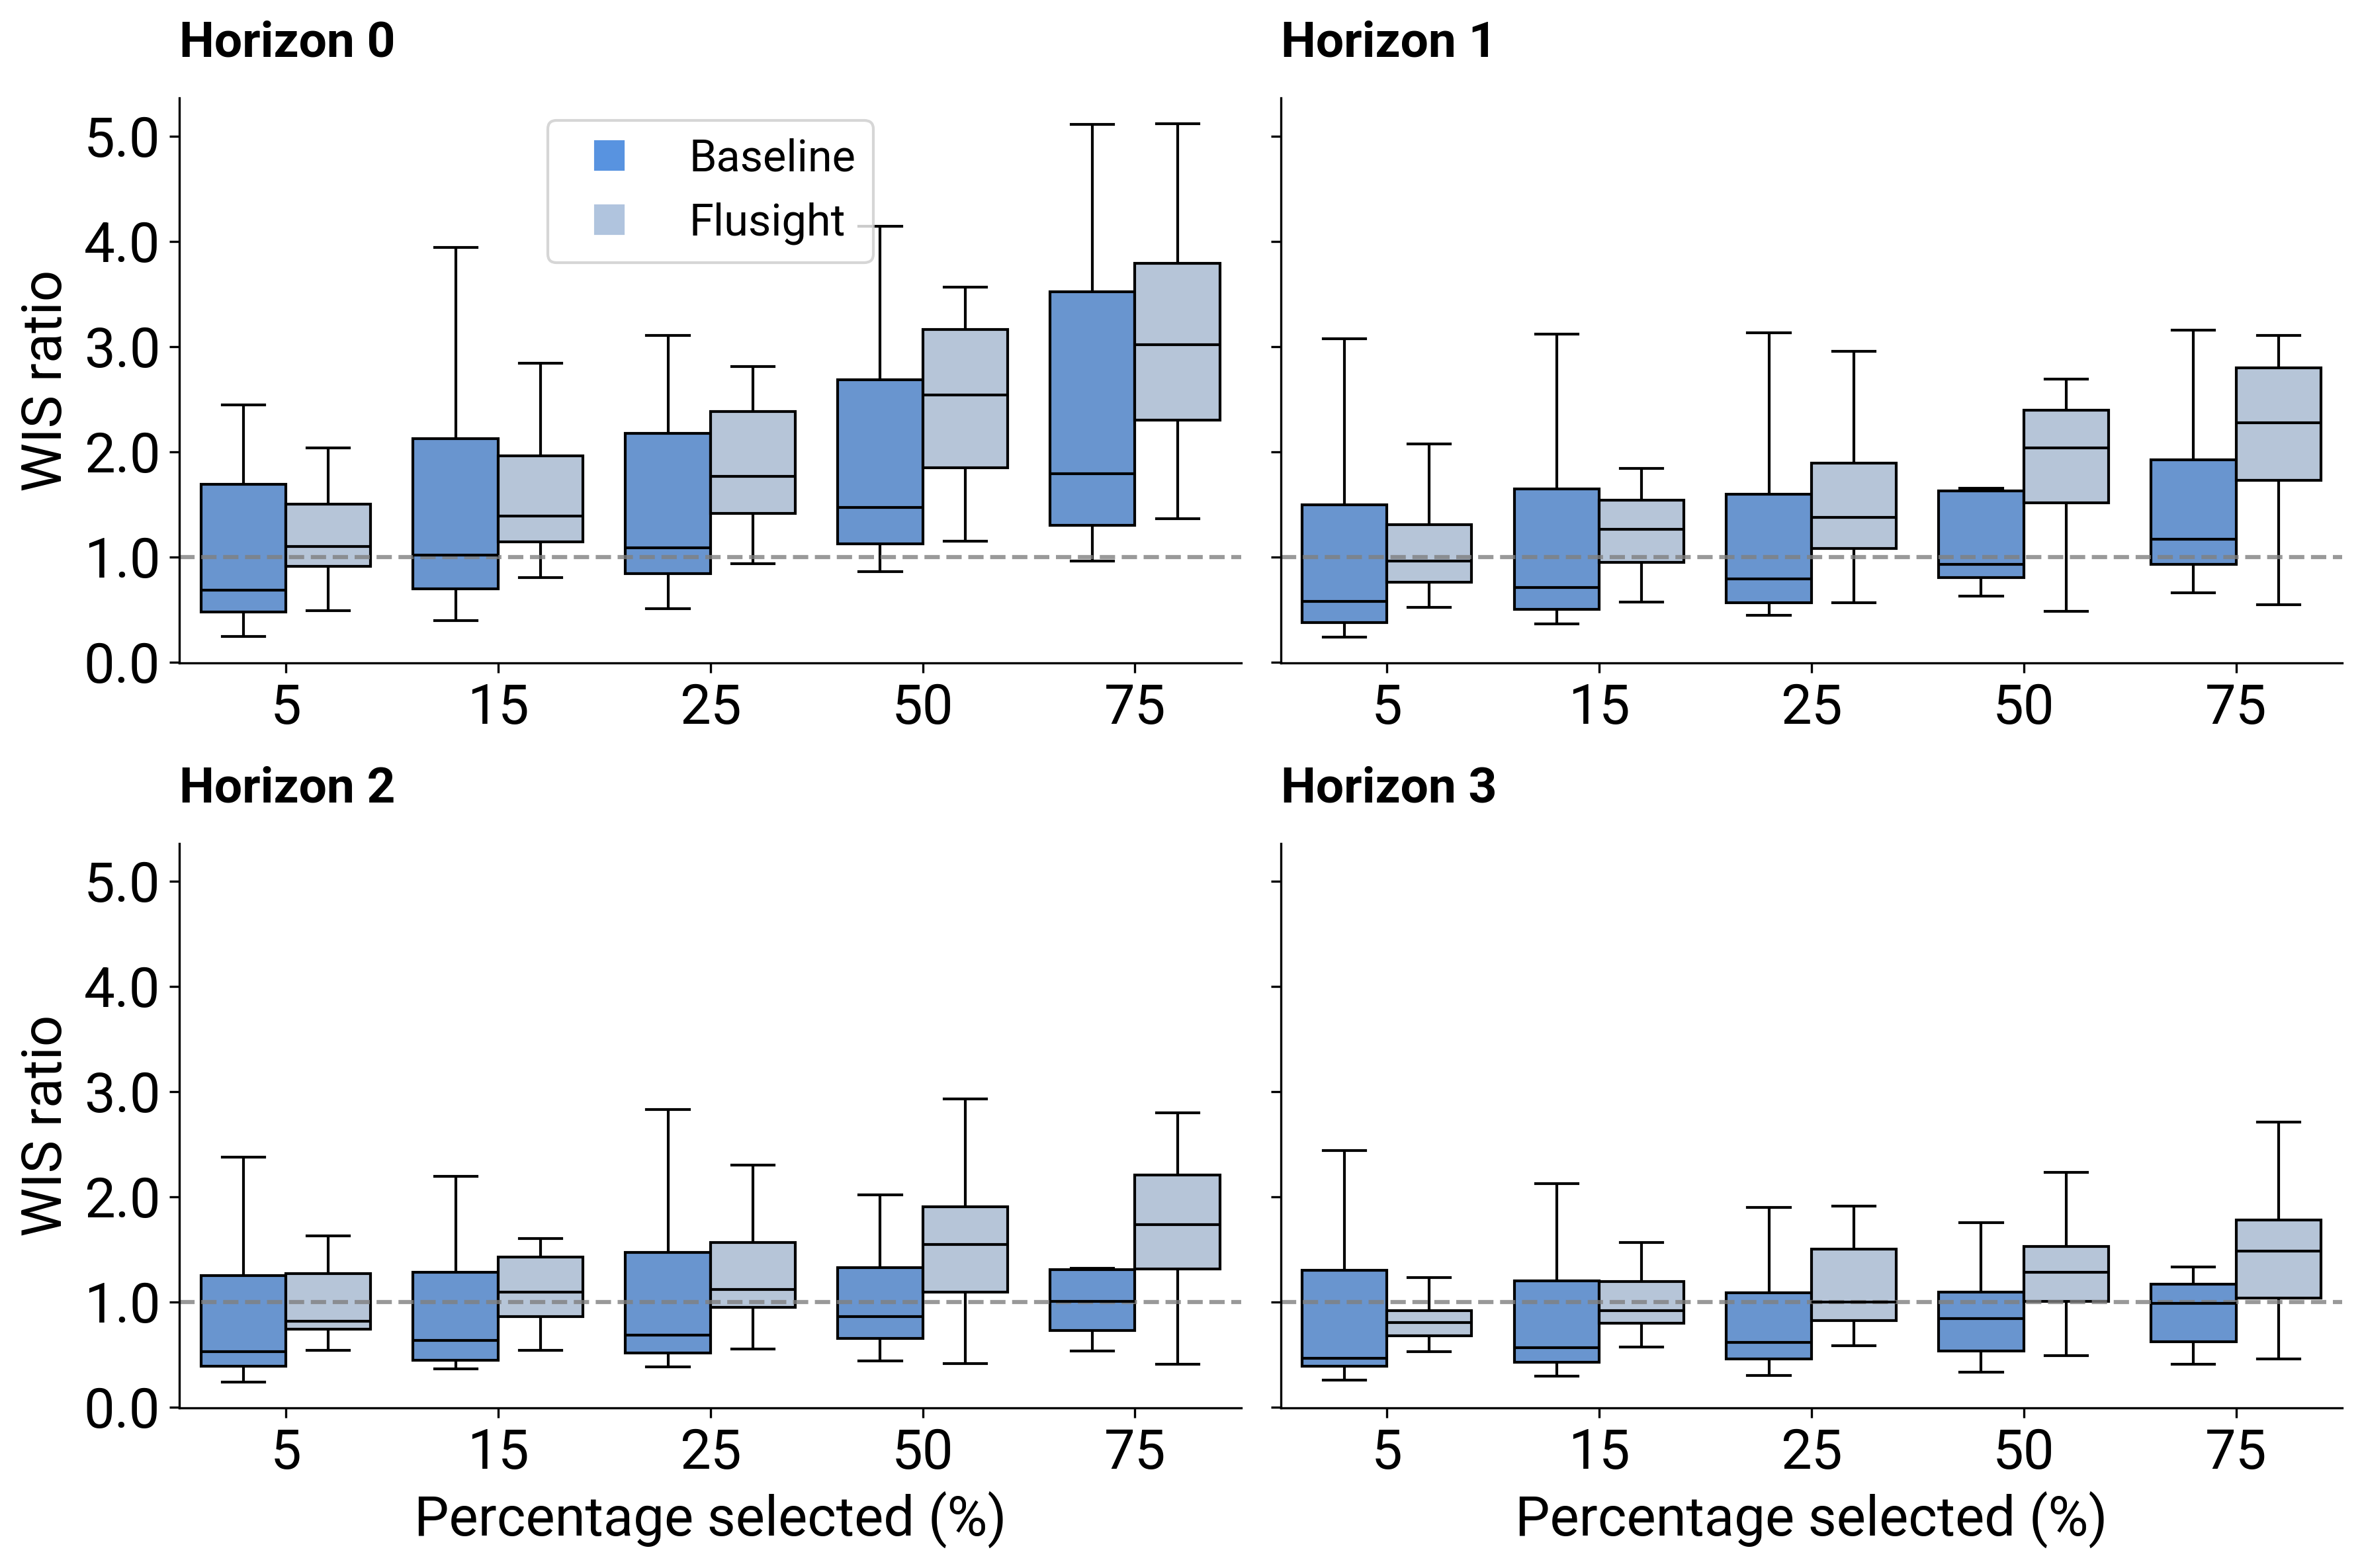

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=300, sharey=True)
plot_index = 0
palette = ['#5893e0', 'lightsteelblue']
labels = ['A.', 'B.'] 
percentages_ticks = [5, 15, 25, 50, 75]

for h in sorted(df_wis['horizon'].unique()):
    df_h = df_wis[df_wis['horizon'] == h].copy()
    df_long = df_h.melt(
        id_vars=["k_perc", "round"],
        value_vars=["wis_adaptive_baseline", "wis_adaptive_flusight"],
        var_name="Group",
        value_name="WIS"
    )
    df_long["Group"] = df_long["Group"].str.replace("wis_adaptive_", "").str.capitalize()
    df_long["Percentage"] = df_long["k_perc"]

    ax = axes[plot_index // 2, plot_index % 2]
    plot_index += 1

    sns.boxplot(
        data=df_long,
        x="Percentage",
        y="WIS",
        hue="Group",
        palette=palette,
        showfliers=False,
        ax=ax,
        boxprops=dict(edgecolor="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        medianprops=dict(color="black")
    )

    ax.axhline(1, color='grey', linestyle='--', alpha=0.8)
    if h in [2, 3]:
        ax.set_xlabel("Percentage selected (%)", fontproperties=font_prop, fontsize=20)
    else:
        ax.set_xlabel("")
    ax.set_ylabel("WIS ratio", fontproperties=font_prop, fontsize=20)
    ax.set_xticklabels(percentages_ticks, fontsize=20, fontproperties=font_prop)
    ax.set_yticklabels(ax.get_yticks(), fontsize=20, fontproperties=font_prop)
    ax.set_title(f"Horizon {h}", loc='left', fontproperties=font_prop_title, fontsize=18, fontweight='bold', pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if h == 0:
        custom_labels = ['Baseline', 'Flusight']
        handles = [
            plt.Line2D([0], [0], color=palette[i], marker='s', linestyle='', markersize=10)
            for i in range(len(custom_labels))
        ]
        ax.legend(handles=handles, labels=custom_labels, prop=font_prop_legend, fontsize=18, title_fontsize=18)
    else:
        ax.get_legend().remove()
plt.tight_layout()
plt.savefig("../figures/wis_horizons_forecasting_supplementary.png", dpi=300)

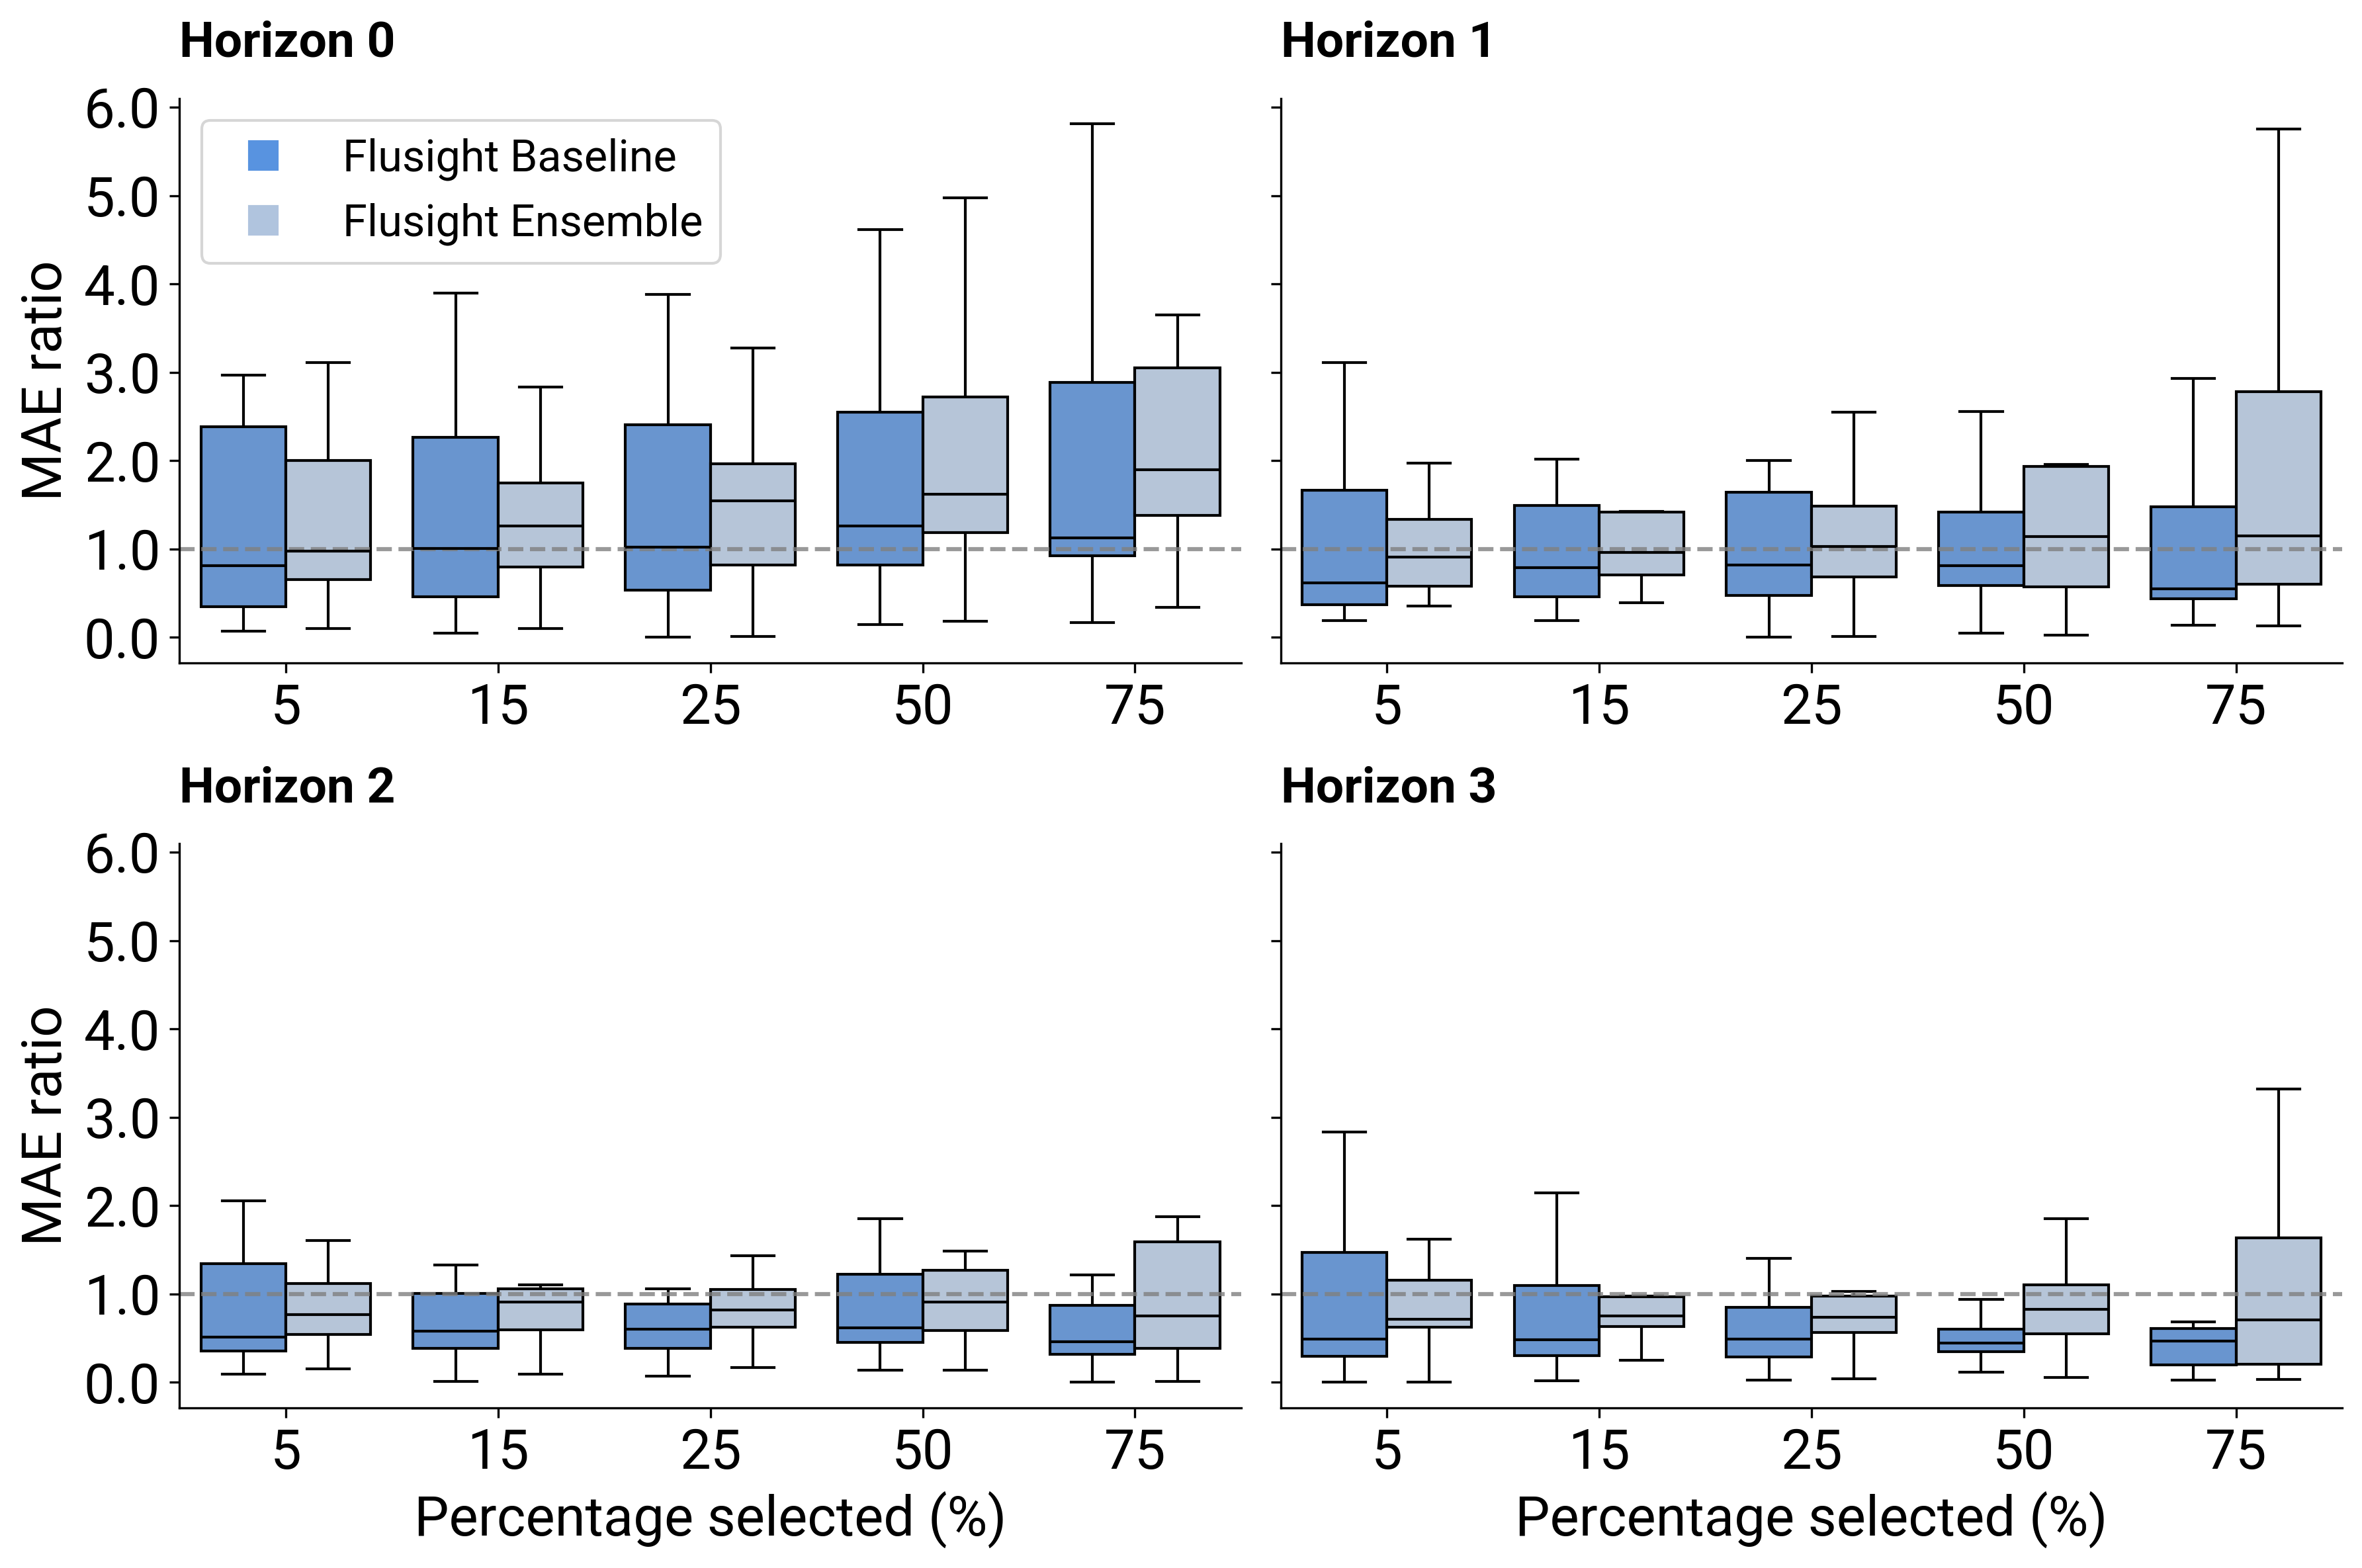

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=300, sharey=True)
plot_index = 0
palette = ['#5893e0', 'lightsteelblue']
labels = ['A.', 'B.'] 
percentages_ticks = [5, 15, 25, 50, 75]

for h in sorted(df_mae['horizon'].unique()):
    df_h = df_mae[df_mae['horizon'] == h].copy()
    df_long = df_h.melt(
        id_vars=["k_perc", "round"],
        value_vars=["mae_adaptive_baseline", "mae_adaptive_flusight"],
        var_name="Group",
        value_name="MAE"
    )
    df_long["Group"] = df_long["Group"].str.replace("mae_adaptive_", "").str.capitalize()
    df_long["Percentage"] = df_long["k_perc"]

    ax = axes[plot_index // 2, plot_index % 2]
    plot_index += 1

    sns.boxplot(
        data=df_long,
        x="Percentage",
        y="MAE",
        hue="Group",
        palette=palette,
        showfliers=False,
        ax=ax,
        boxprops=dict(edgecolor="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        medianprops=dict(color="black")
    )

    ax.axhline(1, color='grey', linestyle='--', alpha=0.8)
    if h in [2, 3]:
        ax.set_xlabel("Percentage selected (%)", fontproperties=font_prop, fontsize=20)
    else:
        ax.set_xlabel("")
    ax.set_ylabel("MAE ratio", fontproperties=font_prop, fontsize=20)
    ax.set_xticklabels(percentages_ticks, fontsize=20, fontproperties=font_prop)
    ax.set_yticklabels(ax.get_yticks(), fontsize=20, fontproperties=font_prop)
    ax.set_title(f"Horizon {h}", loc='left', fontproperties=font_prop_title, fontsize=18, fontweight='bold', pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if h == 0:
        custom_labels = ['Flusight Baseline', 'Flusight Ensemble']
        handles = [
            plt.Line2D([0], [0], color=palette[i], marker='s', linestyle='', markersize=10)
            for i in range(len(custom_labels))
        ]
        ax.legend(handles=handles, labels=custom_labels, prop=font_prop_legend, fontsize=18, title_fontsize=18)
    else:
        ax.get_legend().remove()
plt.tight_layout()
plt.savefig("../figures/mae_horizons_forecasting_supplementary.png", dpi=300)

Plotting WIS and MAE for different k values (across all horizons)

In [25]:
df_wis_mean = df_wis.groupby(['round', 'k_perc'], as_index=False)[
    ['wis_adaptive', 'wis_baseline', 'wis_flusight']
].mean()

# Recompute the ratios
df_wis_mean['wis_adaptive_baseline'] = df_wis_mean['wis_adaptive'] / df_wis_mean['wis_baseline']
df_wis_mean['wis_adaptive_flusight'] = df_wis_mean['wis_adaptive'] / df_wis_mean['wis_flusight']
df_wis_mean

,round,k_perc,wis_adaptive,wis_baseline,wis_flusight,wis_adaptive_baseline,wis_adaptive_flusight
0,6,5,226.459142,589.960544,281.454369,0.383855,0.804603
1,6,15,321.275465,589.960544,281.454369,0.544571,1.141483
2,6,25,407.149012,589.960544,281.454369,0.690129,1.446590
3,6,50,511.504537,589.960544,281.454369,0.867015,1.817362
4,6,75,567.534283,589.960544,281.454369,0.961987,2.016434
...,...,...,...,...,...,...,...
125,31,5,657.980085,1440.446407,752.235265,0.456789,0.874700
126,31,15,837.537141,1440.446407,752.235265,0.581443,1.113398
127,31,25,860.818686,1440.446407,752.235265,0.597605,1.144348
128,31,50,1001.000507,1440.446407,752.235265,0.694924,1.330701


In [28]:
df_mae_mean = df_mae.groupby(['round', 'k_perc'], as_index=False)[
    ['mae_adaptive', 'mae_baseline', 'mae_flusight']
].mean()

# Recompute the ratios
df_mae_mean['mae_adaptive_baseline'] = df_mae_mean['mae_adaptive'] / df_mae_mean['mae_baseline']
df_mae_mean['mae_adaptive_flusight'] = df_mae_mean['mae_adaptive'] / df_mae_mean['mae_flusight']
df_mae_mean

,round,k_perc,mae_adaptive,mae_baseline,mae_flusight,mae_adaptive_baseline,mae_adaptive_flusight
0,6,5,0.090444,0.261115,0.118624,0.346378,0.762448
1,6,15,0.102470,0.261115,0.118624,0.392431,0.863821
2,6,25,0.047682,0.261115,0.118624,0.182609,0.401959
3,6,50,0.053089,0.261115,0.118624,0.203318,0.447545
4,6,75,0.092096,0.261115,0.118624,0.352704,0.776373
...,...,...,...,...,...,...,...
125,31,5,0.162239,0.663223,0.301458,0.244621,0.538180
126,31,15,0.343295,0.663223,0.301458,0.517616,1.138784
127,31,25,0.348579,0.663223,0.301458,0.525584,1.156312
128,31,50,0.409339,0.663223,0.301458,0.617197,1.357866


In [ ]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    filtered_df = df[(df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))]
    return filtered_df

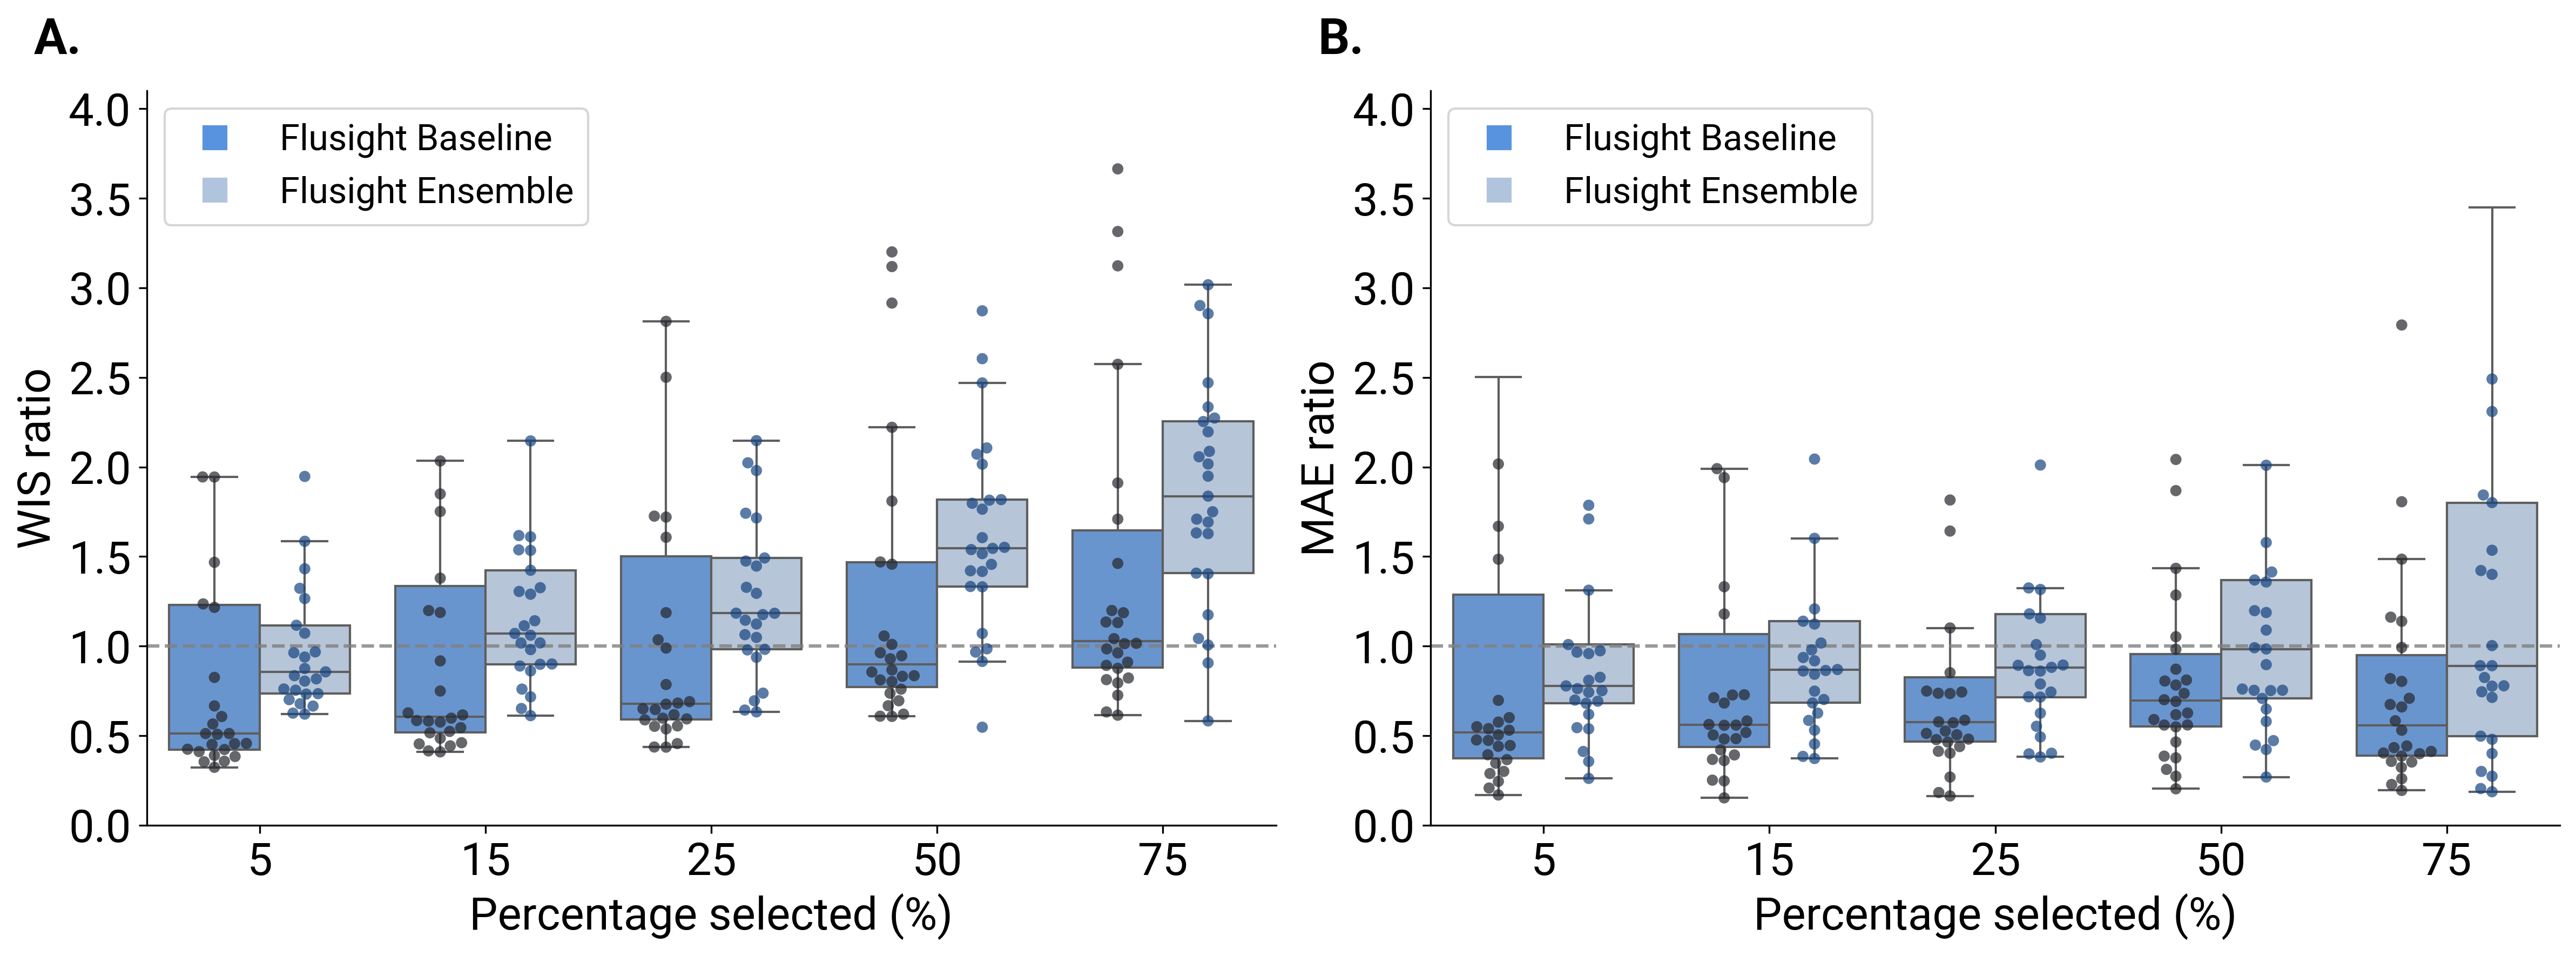

In [35]:
df_long_wis = df_wis_mean.copy()
df_long_wis = df_long_wis.melt(
    id_vars=['round', 'k_perc'],
    value_vars=['wis_adaptive_baseline', 'wis_adaptive_flusight'],
    var_name='Group',
    value_name='WIS'
)
df_long_wis['Group'] = df_long_wis['Group'].str.replace('wis_adaptive_', '', regex=False).str.capitalize()
df_long_wis.rename(columns={'k_perc': 'Percentage'}, inplace=True)

df_long_mae = df_mae_mean.copy()
df_long_mae = df_long_mae.melt(
    id_vars=['round', 'k_perc'],
    value_vars=['mae_adaptive_baseline', 'mae_adaptive_flusight'],
    var_name='Group',
    value_name='MAE'
)
df_long_mae['Group'] = df_long_mae['Group'].str.replace('mae_adaptive_', '', regex=False).str.capitalize()
df_long_mae.rename(columns={'k_perc': 'Percentage'}, inplace=True)


# -- PLOTTING --
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=300)

palette = ['#5893e0', 'lightsteelblue']

# --- WIS Boxplot ---
sns.boxplot(
    data=df_long_wis, 
    x="Percentage", 
    y="WIS", 
    hue="Group", 
    palette=palette, 
    showfliers=False,
    ax=axes[0]
)
for p in df_long_wis['Percentage'].unique():
    df_p = df_long_wis[df_long_wis['Percentage'] == p]
    df_filtered = remove_outliers(df_p, 'WIS')
    sns.swarmplot(
        data=df_filtered,
        x='Percentage',
        y='WIS',
        hue='Group',
        dodge=True,
        color='#164480',
        size=5,
        alpha=0.7,
        ax=axes[0]
    )

axes[0].axhline(1, color='grey', linestyle='--', alpha=0.8)
axes[0].set_xlabel("Percentage selected (%)", fontproperties=font_prop)
axes[0].set_ylabel("WIS ratio", fontproperties=font_prop)
axes[0].set_ylim(0, 4.1)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].text(-0.1, 1.05, 'A.', transform=axes[0].transAxes, fontproperties=font_prop_title)

# --- MAE Boxplot ---
sns.boxplot(
    data=df_long_mae, 
    x="Percentage", 
    y="MAE", 
    hue="Group", 
    palette=palette, 
    showfliers=False,
    ax=axes[1]
)
for p in df_long_mae['Percentage'].unique():
    df_p = df_long_mae[df_long_mae['Percentage'] == p]
    df_filtered = remove_outliers(df_p, 'MAE')
    sns.swarmplot(
        data=df_filtered,
        x='Percentage',
        y='MAE',
        hue='Group',
        dodge=True,
        color='#164480',
        size=5,
        alpha=0.7,
        ax=axes[1]
    )

axes[1].axhline(1, color='grey', linestyle='--', alpha=0.8)
axes[1].set_xlabel("Percentage selected (%)", fontproperties=font_prop)
axes[1].set_ylabel("MAE ratio", fontproperties=font_prop)
axes[1].set_ylim(0, 4.1)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].text(-0.1, 1.05, 'B.', transform=axes[1].transAxes, fontproperties=font_prop_title)

for ax in axes:
    for label in ax.get_yticklabels() + ax.get_xticklabels():
        label.set_fontproperties(font_prop)
custom_labels = ['Flusight Baseline', 'Flusight Ensemble']
handles = [plt.Line2D([0], [0], color=palette[i], marker='s', linestyle='', markersize=10) for i in range(len(custom_labels))]
axes[0].legend(handles=handles, labels=custom_labels, loc='upper left', prop=font_prop_legend)
axes[1].legend(handles=handles, labels=custom_labels, loc='upper left', prop=font_prop_legend)

plt.tight_layout()
plt.savefig("../figures/wis_mae_forecasting_k_main.png", dpi=300)


Plot coverage for k=25

In [ ]:
# Coverage intervals (assumendo che siano questi nel tuo df)
alpha_vals = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.975]
alphas = ["{:.2f}".format((1 - a) / 2) for a in alpha_vals]
upper_alphas = ["{:.2f}".format(1 - (1 - a) / 2) for a in alpha_vals]
alpha_labels = [f"{a}-{b}" for a, b in zip(alphas, upper_alphas)]
selected_k = 25

fig, axs = plt.subplots(2, 2, figsize=(14, 10), dpi=300)
axs = axs.ravel()

for horizon in range(4):
    ax = axs[horizon]
    df_plot = df_cov[(df_cov["k_perc"] == selected_k) & (df_cov["horizon"] == horizon)]

    cov_adaptive_means = [df_plot[f"cov_adaptive_{label}"].mean() for label in alpha_labels]
    cov_baseline_means = [df_plot[f"cov_baseline_{label}"].mean() for label in alpha_labels]
    cov_flusight_means = [df_plot[f"cov_flusight_{label}"].mean() for label in alpha_labels]

    ax.plot(alpha_vals, cov_adaptive_means, label='Adaptive Ensemble', marker='o', linestyle='-', color='#164480')
    ax.plot(alpha_vals, cov_baseline_means, label='FluSight Baseline', marker='x', linestyle='--', color='#5893e0')
    ax.plot(alpha_vals, cov_flusight_means, label='FluSight Ensemble', marker='s', linestyle='-.', color='lightsteelblue')
    
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')

    ax.set_title(f"Horizon {horizon}", fontproperties=font_prop_title)
    ax.set_xlabel("Nominal Coverage", fontproperties=font_prop)
    ax.set_ylabel("Prediction Coverage", fontproperties=font_prop)

    ax.tick_params(labelsize=15)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(font_prop)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    if horizon == 0:
        ax.legend(prop=font_prop_legend)

plt.tight_layout()
plt.savefig("../figures/coverage_forecasting_k25.png", dpi=300)


Plot coverage for k=5 and k=50

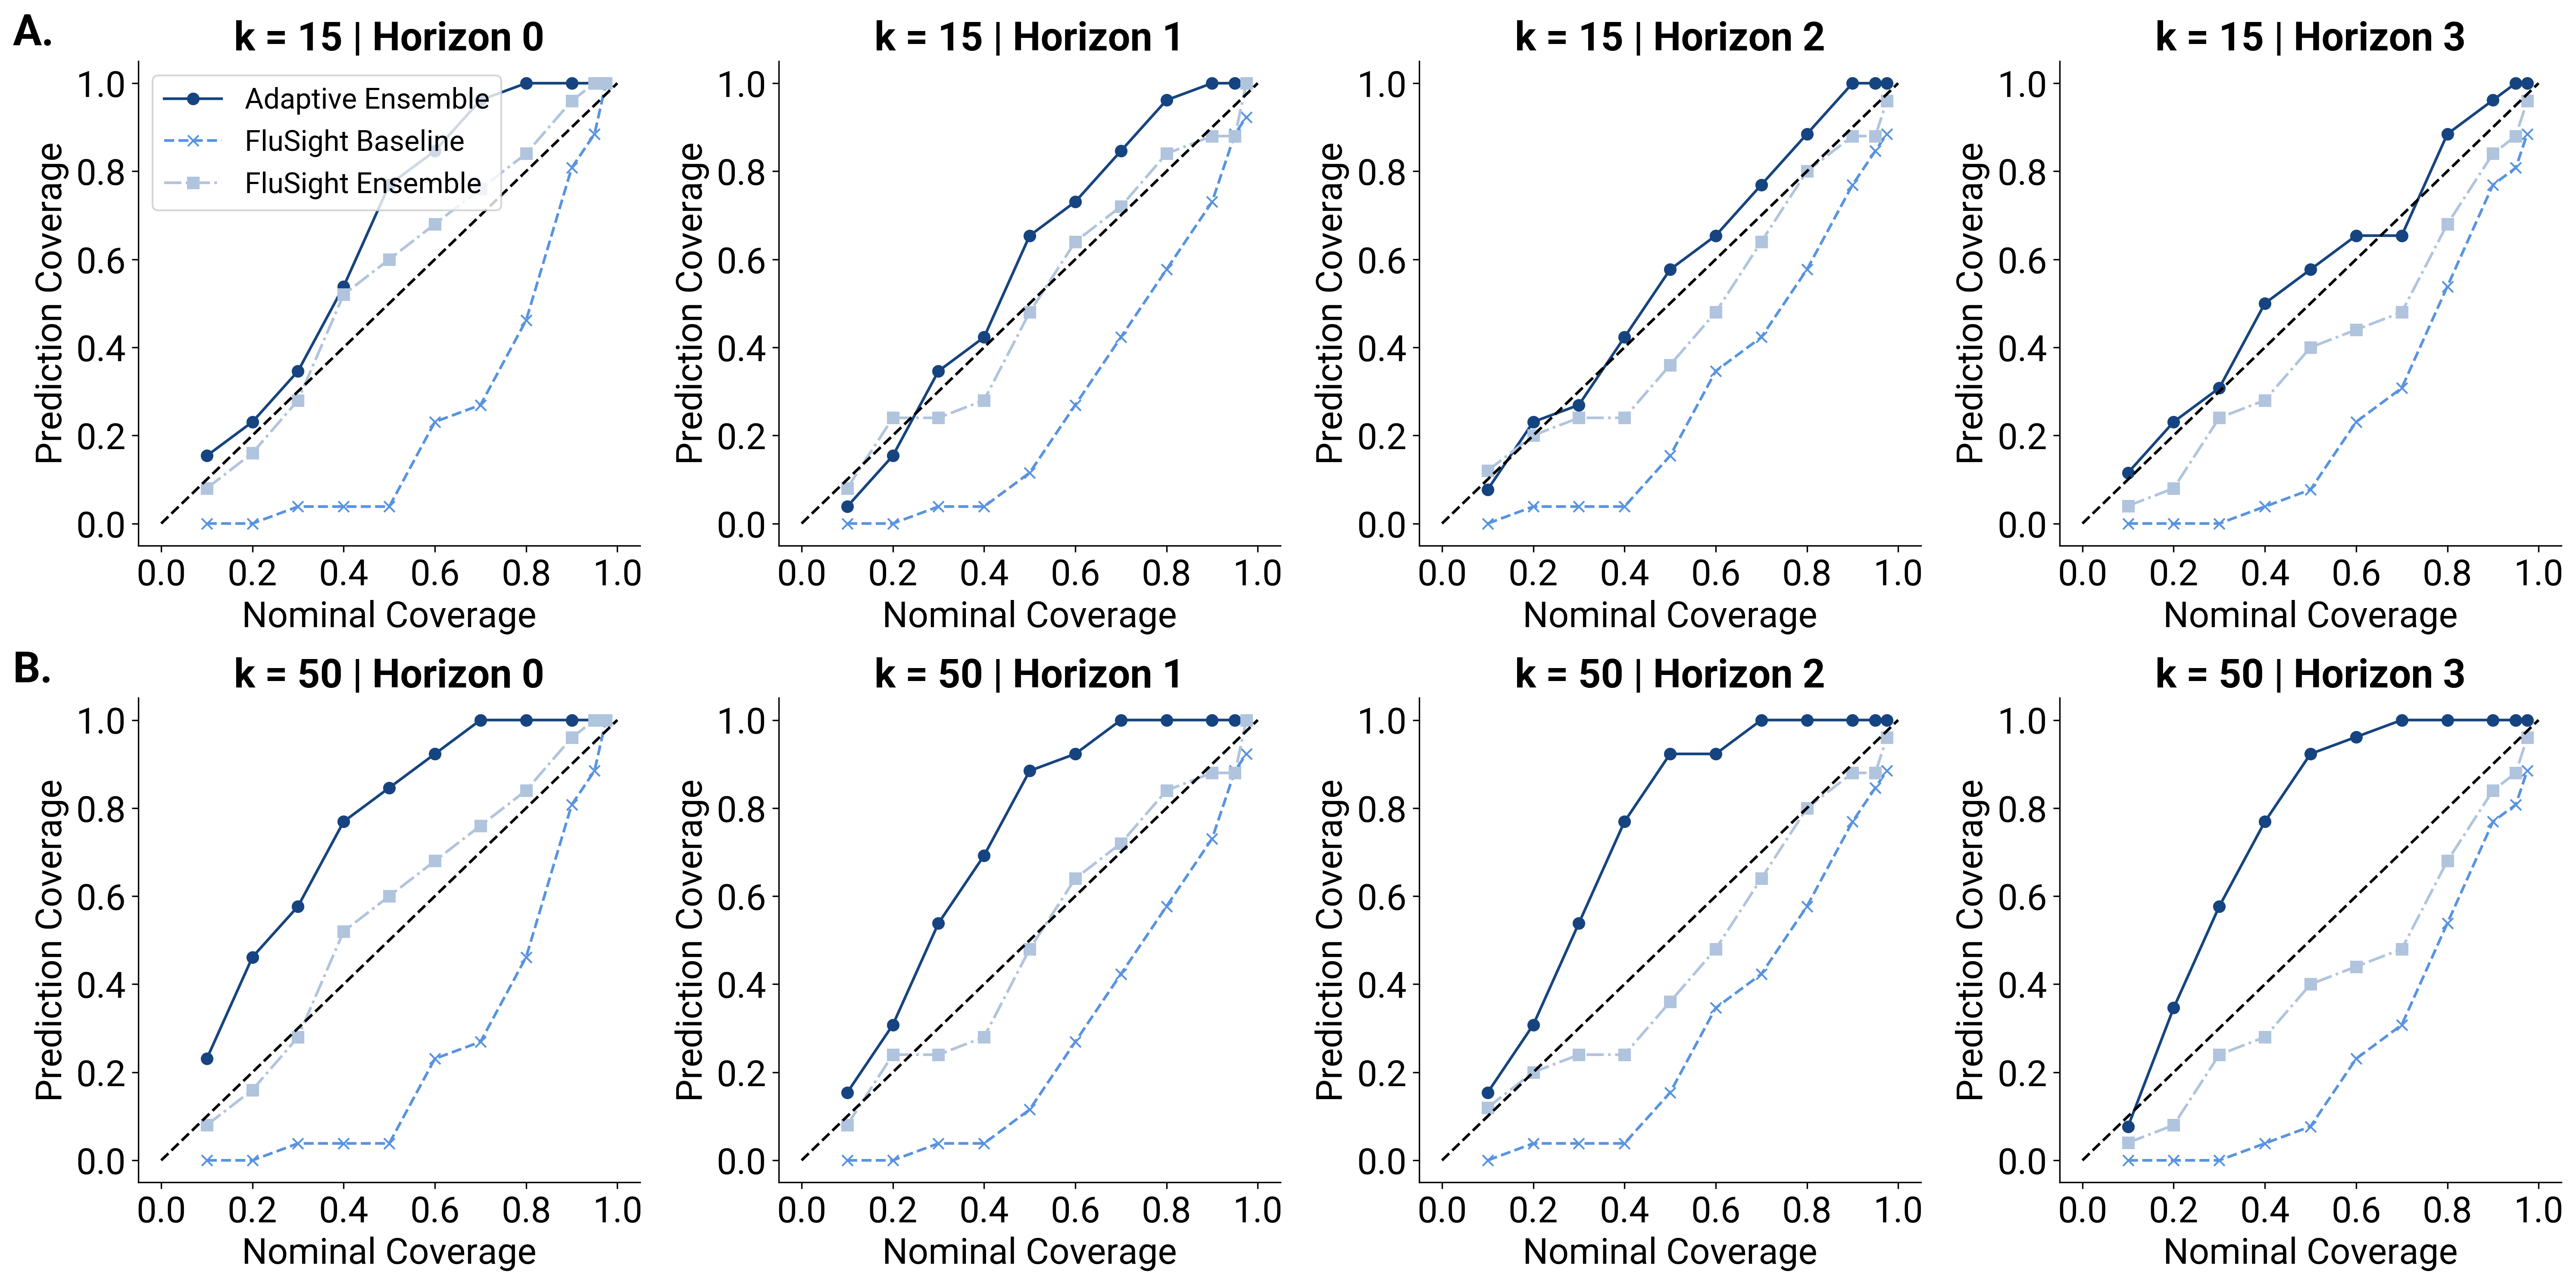

In [ ]:
alpha_vals = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.975]
alphas = ["{:.2f}".format((1 - a) / 2) for a in alpha_vals]
upper_alphas = ["{:.2f}".format(1 - (1 - a) / 2) for a in alpha_vals]
alpha_labels = [f"{a}-{b}" for a, b in zip(alphas, upper_alphas)]
k_values = [15, 50]

fig, axs = plt.subplots(2, 4, figsize=(20, 10), dpi=300)
axs = axs.ravel()

plot_idx = 0

for row_idx, k in enumerate(k_values):
    for horizon in range(4):
        ax = axs[plot_idx]
        df_plot = df_cov[(df_cov["k_perc"] == k) & (df_cov["horizon"] == horizon)]

        cov_adaptive_means = [df_plot[f"cov_adaptive_{label}"].mean() for label in alpha_labels]
        cov_baseline_means = [df_plot[f"cov_baseline_{label}"].mean() for label in alpha_labels]
        cov_flusight_means = [df_plot[f"cov_flusight_{label}"].mean() for label in alpha_labels]

        ax.plot(alpha_vals, cov_adaptive_means, label='Adaptive Ensemble', marker='o', linestyle='-', color='#164480')
        ax.plot(alpha_vals, cov_baseline_means, label='FluSight Baseline', marker='x', linestyle='--', color='#5893e0')
        ax.plot(alpha_vals, cov_flusight_means, label='FluSight Ensemble', marker='s', linestyle='-.', color='lightsteelblue')

        ax.plot([0, 1], [0, 1], color='black', linestyle='--')

        ax.set_title(f"k = {k} | Horizon {horizon}", fontproperties=font_prop_title)
        ax.set_xlabel("Nominal Coverage", fontproperties=font_prop)
        ax.set_ylabel("Prediction Coverage", fontproperties=font_prop)

        ax.tick_params(labelsize=15)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontproperties(font_prop)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)

        if plot_idx == 0:
            ax.legend(prop=font_prop_legend)

        if horizon == 0:
            label = "A." if row_idx == 0 else "B."
            ax.text(-0.25, 1.1, label, transform=ax.transAxes,
                    fontproperties=font_prop_title, fontsize=24, fontweight='bold', va='top', ha='left')

        plot_idx += 1

plt.tight_layout()
plt.savefig("../figures/coverage_forecasting_k15_k50_supplementary.png", dpi=300)

